In [12]:
import pandas as pd
import hypernetx as hnx
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain


In [13]:
!pip install hypernetx

In [14]:
df = pd.read_csv('symbipredict_2022.csv')

In [15]:
df = df.groupby('prognosis').max()

In [16]:
diseases = df['prognosis'].unique().tolist()
symptoms = df.columns[df.columns != 'prognosis'].tolist()

KeyError: 'prognosis'

In [9]:
hypergraph = hnx.Hypergraph()

In [10]:
hypergraph = {symptom: set() for symptom in symptoms}

for disease in diseases:
    disease_data = df[df['prognosis'] == disease]
    for _, row in disease_data.iterrows():
        for j, symptom in enumerate(symptoms):
            if row[j+1] == 1:
                hypergraph[symptom].add(disease)
hypergraph = {symptom: list(disease_set) for symptom, disease_set in hypergraph.items()}


<ipython-input-10-6ac308537980>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[j+1] == 1:  # Assuming column 0 is 'prognosis'


**Union symptoms**

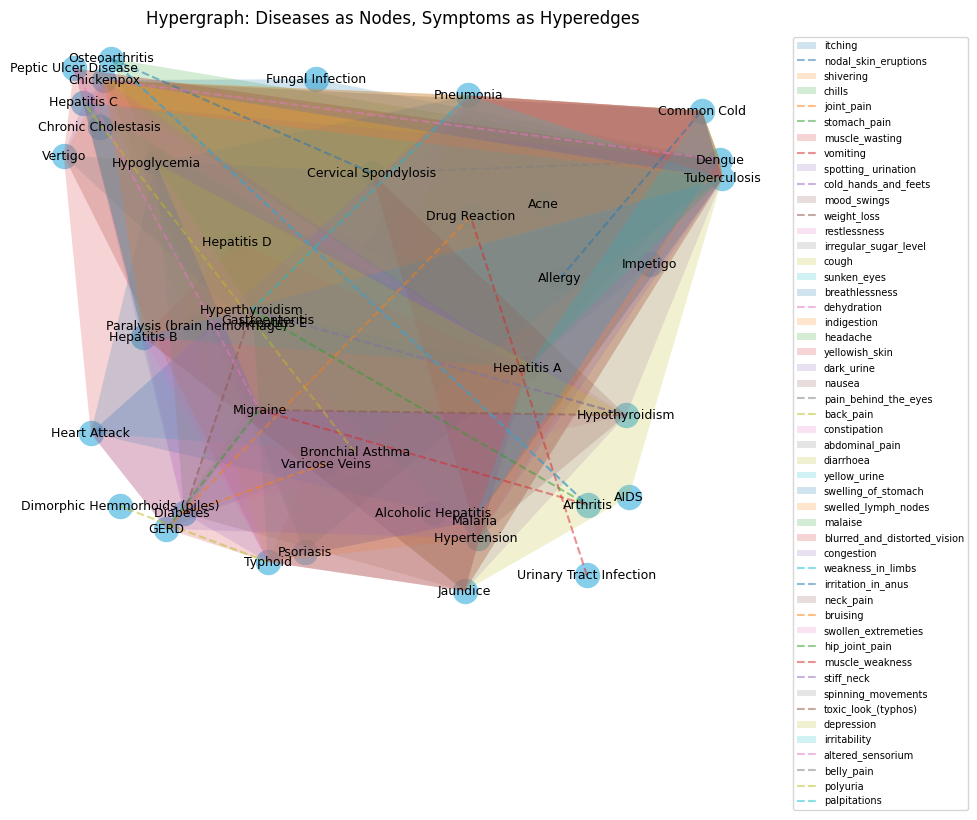

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

np.random.seed(42)
positions = {
    disease: (np.random.uniform(0, 10), np.random.uniform(0, 10))
    for disease in diseases
}


plt.figure(figsize=(10, 8))
for disease, (x, y) in positions.items():
    plt.scatter(x, y, color='skyblue', s=300)
    plt.text(x, y, disease, ha='center', va='center', fontsize=9)

for symptom, disease_list in hypergraph.items():
    points = np.array([positions[d] for d in disease_list if d in positions])
    if len(points) >= 3:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        plt.fill(hull_points[:, 0], hull_points[:, 1], alpha=0.2, label=symptom)
    elif len(points) == 2:
        plt.plot(points[:, 0], points[:, 1], linestyle='--', alpha=0.5, label=symptom)

plt.title("Hypergraph: Diseases as Nodes, Symptoms as Hyperedges")
plt.axis('off')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=7)
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain

symptoms = df.columns[1:]
H = df[symptoms].values

Dv = np.sum(H, axis=1)

Dv[Dv == 0] = 1

De = np.sum(H, axis=0)

De[De == 0] = 1

W = np.ones_like(De, dtype=float)


def compute_reduced_adjacency_matrix(H, De, W):
    De_inv = np.diag(1.0 / De)
    return np.dot(np.dot(H, np.diag(W)), np.dot(De_inv, H.T))


def louvain_modularity_maximization(A):
    G = nx.from_numpy_array(A)
    partition = community_louvain.best_partition(G)
    return partition, len(set(partition.values()))


def update_hyperedge_weights(H, symptoms, cluster_assignments):
    new_weights = []
    for j, symptom in enumerate(symptoms):

        cluster_sums = {}
        for disease_idx, cluster_id in cluster_assignments.items():
            if H[disease_idx, j] == 1:
                cluster_sums[cluster_id] = cluster_sums.get(cluster_id, 0) + 1

        if cluster_sums:
            new_weight = sum(cluster_sums.values()) / len(cluster_sums)
        else:
            new_weight = 1.0
        new_weights.append(new_weight)
    return np.array(new_weights)

threshold = 1e-4
max_iterations = 10
iteration = 0
W_prev = np.copy(W)
while iteration < max_iterations:
    A = compute_reduced_adjacency_matrix(H, De, W)

    A = (A + A.T) / 2
    A[A < 0] = 0

    cluster_assignments, num_clusters = louvain_modularity_maximization(A)

    new_weights = update_hyperedge_weights(H, symptoms, cluster_assignments)

    W = 0.5 * (new_weights + W_prev)

    if np.linalg.norm(W - W_prev) < threshold:
        print(f"Converged after {iteration + 1} iterations")
        break

    W_prev = np.copy(W)
    iteration += 1
else:
    print(f"Reached maximum iterations ({max_iterations}) without convergence")

print("Cluster Assignments:", cluster_assignments)
print("Number of Clusters:", num_clusters)

Reached maximum iterations (10) without convergence
Cluster Assignments: {0: 3, 1: 1, 2: 8, 3: 9, 4: 4, 5: 0, 6: 6, 7: 1, 8: 8, 9: 0, 10: 1, 11: 2, 12: 5, 13: 1, 14: 1, 15: 0, 16: 5, 17: 0, 18: 8, 19: 8, 20: 8, 21: 8, 22: 8, 23: 6, 24: 2, 25: 2, 26: 2, 27: 1, 28: 8, 29: 5, 30: 2, 31: 4, 32: 5, 33: 8, 34: 0, 35: 1, 36: 0, 37: 5, 38: 1, 39: 7, 40: 6}
Number of Clusters: 10


<ipython-input-21-eb96e1bb9bdf>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters)  # Use tab10 colormap


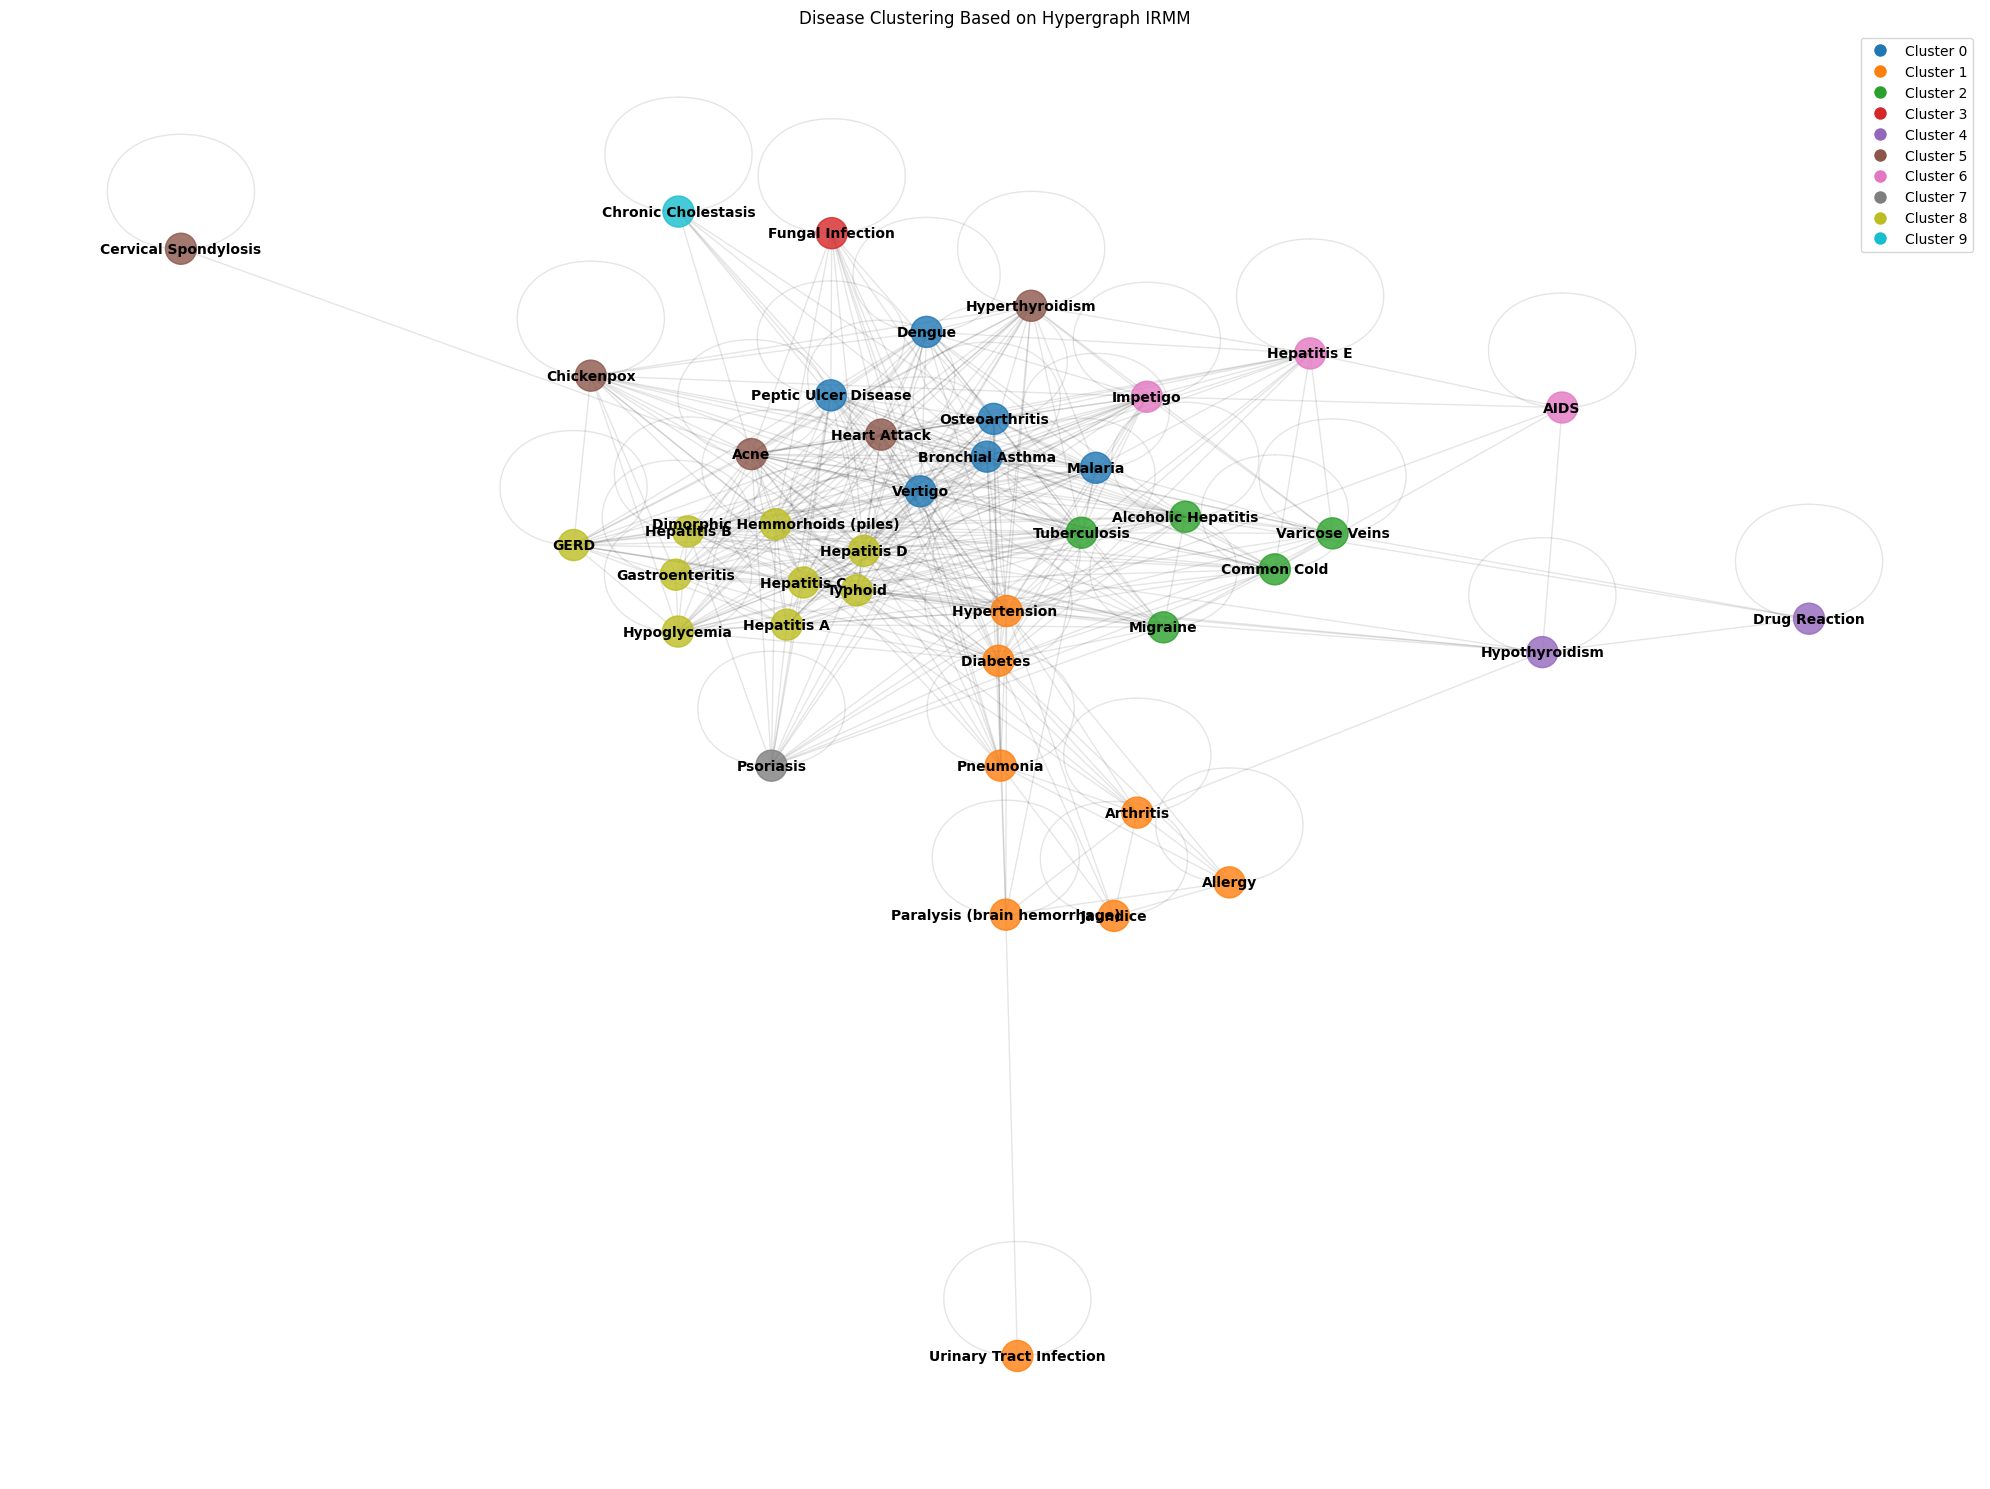

In [21]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
def visualize_clustering(A, cluster_assignments, num_clusters, disease_names):

    G = nx.from_numpy_array(A)

    mapping = {i: name for i, name in enumerate(disease_names)}
    G = nx.relabel_nodes(G, mapping)

    colors = plt.cm.get_cmap('tab10', num_clusters)
    node_colors = [colors(cluster_assignments[i]) for i in range(len(disease_names))]

    pos = nx.spring_layout(G, seed=42)


    plt.figure(figsize=(20, 15))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, alpha=0.1)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
               markerfacecolor=colors(i), markersize=10)
        for i in range(num_clusters)
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Disease Clustering Based on Hypergraph IRMM")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize_clustering(A, cluster_assignments, num_clusters, diseases)

In [23]:
unique_prognoses = df.index.unique().tolist()
cluster_table = pd.DataFrame({
    'Disease': unique_prognoses,
    'Cluster': [cluster_assignments[i] for i in range(len(df))]
})

cluster_table.to_csv('disease_clusters_IRMM.csv', index=False)

print(cluster_table)

                          Disease  Cluster
0                            AIDS        3
1                            Acne        1
2             Alcoholic Hepatitis        8
3                         Allergy        9
4                       Arthritis        4
5                Bronchial Asthma        0
6            Cervical Spondylosis        6
7                      Chickenpox        1
8             Chronic Cholestasis        8
9                     Common Cold        0
10                         Dengue        1
11                      Diabetes         2
12  Dimorphic Hemmorhoids (piles)        5
13                  Drug Reaction        1
14               Fungal Infection        1
15                           GERD        0
16                Gastroenteritis        5
17                   Heart Attack        0
18                    Hepatitis A        8
19                    Hepatitis B        8
20                    Hepatitis C        8
21                    Hepatitis D        8
22         